## Clustering

ドキュメント：[K-Means Clustering](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/k-means.html)

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
%matplotlib inline
import matplotlib.pyplot as plt

### 擬似データの作成  
- 2次元の擬似データ（３クラスター）を作成し、プロット

In [2]:
#> 擬似データ（３つの中心点を指定して乱数で作成）の作成
X, labels_true = make_blobs(
    n_samples=1500,                      # サンプル数
    centers=[[-3,-3],[0,3],[3,-3]],  # クラスタ重心座標設定(3クラスタを2次元で作成)
    cluster_std=1.8,                         # 乱数生成時の標準偏差
    random_state=0)
print('Xの次元: ', X.shape)
pd.DataFrame(np.c_[X, labels_true], columns=["X0","X1","label"]).head()

Xの次元:  (1500, 2)


,X0,X1,label
0,3.082149,1.574193,1.0
1,4.487026,-3.103962,2.0
2,0.827253,3.504104,1.0
3,-2.153220,-2.439395,0.0
4,-2.193248,0.053127,0.0


<AxesSubplot:xlabel='X0', ylabel='X1'>

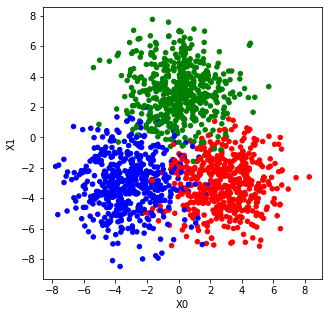

In [3]:
#> クラスターを色分けしてプロット
df = pd.DataFrame(np.hstack([X,labels_true.reshape(len(labels_true),1)]), columns=["X0","X1","label"])
col = df.label.map({0:'b', 1:'g', 2:'r'})
df.plot(x='X0', y='X1', kind='scatter', c=col, colorbar=False, figsize=(5,5))

### H2O-3によるクラスタリング（k-means）

In [4]:
import h2o
print(h2o.__version__)

3.32.0.2


In [5]:
from h2o.estimators.kmeans import H2OKMeansEstimator

APIドキュメント：[H2OKMeansEstimator](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2okmeansestimator)

In [7]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_YShimada_MBP16_jmzf64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


#### クラスター数を指定し、クラスタリングを実施

In [8]:
#> データの準備： pandas DataFrameからH2O Frameへ変換
print(type(df))
df_h2o = h2o.H2OFrame.from_python(df)
print(type(df_h2o))

<class 'pandas.core.frame.DataFrame'>
Parse progress: |█████████████████████████████████████████████████████████| 100%
<class 'h2o.frame.H2OFrame'>


In [9]:
#> クラスター数（k）を明示的に指定し、モデルインスタンスを作成
km_k3 = H2OKMeansEstimator(standardize=True, 
                                                        estimate_k=False,       # estimate_kをFalseとし、
                                                        k=3,                               # kにクラスター数を指定
                                                        seed=123)
km_k3

No model trained yet


In [10]:
#> モデル学習（クラスター中心点の推定）
km_k3.train(x=["X0","X1"], training_frame=df_h2o)
km_k3

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1608606187338_1


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,1500.0,3.0,0.0,7.0,838.863783,2998.0,2159.136217




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 838.8637840019568
Total Sum of Square Error to Grand Mean: 2998.000005680511
Between Cluster Sum of Square Error: 2159.136221678554

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,491.0,271.723761
1,,2.0,514.0,283.424398
2,,3.0,495.0,283.715626



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-12-22 12:03:14,0.028 sec,0.0,NaN,NaN
1,,2020-12-22 12:03:14,0.079 sec,1.0,1500.0,2188.208893
2,,2020-12-22 12:03:14,0.094 sec,2.0,198.0,977.289399
3,,2020-12-22 12:03:14,0.097 sec,3.0,66.0,860.884308
4,,2020-12-22 12:03:14,0.099 sec,4.0,32.0,842.698848
5,,2020-12-22 12:03:14,0.102 sec,5.0,8.0,839.068312
6,,2020-12-22 12:03:14,0.105 sec,6.0,2.0,838.875864
7,,2020-12-22 12:03:14,0.107 sec,7.0,0.0,838.863783


In [11]:
#> モデルパラメータの確認
km_k3.actual_params

{'model_id': 'KMeans_model_python_1608606187338_1',
 'training_frame': 'Key_Frame__upload_b29cc88d561d8e97a3890546c06d4703.hex',
 'validation_frame': None,
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': None,
 'fold_column': None,
 'ignored_columns': ['label'],
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'k': 3,
 'estimate_k': False,
 'user_points': None,
 'max_iterations': 10,
 'standardize': True,
 'seed': 123,
 'init': 'Furthest',
 'max_runtime_secs': 0.0,
 'categorical_encoding': 'Enum',
 'export_checkpoints_dir': None,
 'cluster_size_constraints': None}

In [12]:
#> 各クラスターの中心点
km_k3.centers()
# ほぼほぼ一致

[[-3.247400935952182, -3.113117564802373],
 [2.9036799342177506, -2.976073993746822],
 [-0.013449126600657065, 3.066099904291491]]

In [13]:
#> 各データ点をクラスターに振り分ける
pred_k3 = km_k3.predict(df_h2o)

kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [14]:
#> 振り分けたクラスター番号を元データに結合
df_h2o['label_pred'] = pred_k3
df_h2o.head(8)

X0,X1,label,label_pred
3.08215,1.57419,1,2
4.48703,-3.10396,2,1
0.827253,3.5041,1,2
-2.15322,-2.4394,0,0
-2.19325,0.0531268,0,0
-1.89466,-1.34003,0,0
2.73425,-0.962738,2,1
-2.88027,-2.45555,0,0


<AxesSubplot:xlabel='X0', ylabel='X1'>

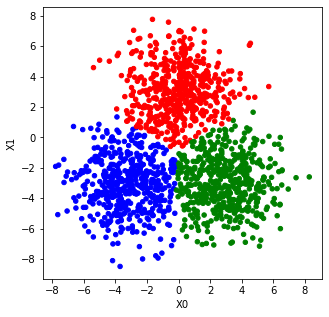

In [15]:
#> クラスター分析結果をプロット
df2 = df_h2o.as_data_frame()
col = df2.label_pred.map({0:'b', 1:'g', 2:'r'})
df2.plot(x='X0', y='X1', kind='scatter', c=col, colorbar=False, figsize=(5,5))

#### 検証データによる、クラスター数の決定

In [16]:
#> データの準備
# pandas DataFrameからH2O Frameへ変換
df_h2o = h2o.H2OFrame.from_python(df)
# 学習、検証データへの分割
df_h2o_train, df_h2o_valid = df_h2o.split_frame(ratios=[.8], seed=1234)
print("学習データの次元（ラベル付）：", df_h2o_train.shape)
print("検証データの次元（ラベル付）：", df_h2o_valid.shape)

Parse progress: |█████████████████████████████████████████████████████████| 100%
学習データの次元（ラベル付）： (1210, 3)
検証データの次元（ラベル付）： (290, 3)


In [17]:
#> モデルインスタンスの作成
km_auto = H2OKMeansEstimator(standardize=True, 
                                                           estimate_k=True,    # estimate_kをTrueとし、
                                                           k = 10,                       # 探索する最大クラスター数を指定する
                                                           seed=1234)
km_auto

No model trained yet


In [18]:
km_auto.train(x=["X0","X1"], 
                          training_frame=df_h2o_train, 
                          validation_frame=df_h2o_valid)
km_auto

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1608606187338_2


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,1210.0,1.0,0.0,2.0,2418.0,2418.0,0.0




ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 2417.9999992370404
Total Sum of Square Error to Grand Mean: 2417.999998850979
Between Cluster Sum of Square Error: -3.860614015138708e-07

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,1210.0,2417.999999



ModelMetricsClustering: kmeans
** Reported on validation data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 598.7492430154668
Total Sum of Square Error to Grand Mean: 592.733482900468
Between Cluster Sum of Square Error: -6.015760114998898

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,290.0,598.749243



Scoring History: 


,,timestamp,duration,iterations,number_of_clusters,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2020-12-22 12:03:27,0.005 sec,0.0,0.0,NaN,NaN
1,,2020-12-22 12:03:27,0.010 sec,1.0,1.0,1210.0,5325.721459
2,,2020-12-22 12:03:27,0.011 sec,2.0,1.0,0.0,2418.000000


In [21]:
#>>> うまくクラスター数が決定されていない、、。

In [19]:
#km_auto.actual_params

In [20]:
#> 各クラスターの中心点
km_auto.centers()

[[-0.01603850588870479, -0.9585472063053901]]